In [1]:
import gym
import numpy as np
from collections import deque
from tqdm import tqdm
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
1
NVIDIA GeForce RTX 3050 Laptop GPU


In [5]:
class DuelingDQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DuelingDQN, self).__init__()
        self.feature = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )

        self.value = nn.Linear(128, 1)
        self.advantage = nn.Linear(128, action_dim)

    def forward(self, state):
        features = self.feature(state)
        values = self.value(features)
        advantages = self.advantage(features)
        qvals = values + (advantages - advantages.mean(dim=-1, keepdim=True))

        return qvals

In [6]:
class DuelingDQNAgent:
    def __init__(self, state_dim, action_dim):
        self.action_dim = action_dim

        self.q_net = DuelingDQN(state_dim, action_dim).to(device)
        print(f"Q-network device: {next(self.q_net.parameters()).device}")
        self.target_q_net = DuelingDQN(state_dim, action_dim).to(device)
        print(f"Target Q-network device: {next(self.target_q_net.parameters()).device}")
        self.optimizer = optim.Adam(self.q_net.parameters())

        self.replay_buffer = deque(maxlen=10000)
        self.gamma = 0.99

    def get_action(self, state, eps):
        if np.random.random() < eps:
            return np.random.choice(self.action_dim)
        else:
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            print(f"State tensor device: {state.device}")
            q_values = self.q_net(state)
            return q_values.argmax().item()

    def update(self, batch_size):
        state, action, reward, next_state, done = self.sample_batch(batch_size)

        action = action.long().to(device)
        state = state.to(device)
        next_state = next_state.to(device)
        reward = reward.to(device)
        done = done.to(device)

        q_values = self.q_net(state).gather(1, action.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_q_net(next_state).max(1)[0]
        expected_q_values = reward + self.gamma * next_q_values * (1 - done)

        loss = nn.MSELoss()(q_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def sample_batch(self, batch_size):
        batch = random.sample(self.replay_buffer, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return map(lambda x: torch.FloatTensor(x).to(device), (state, action, reward, next_state, done))

    def update_target_net(self):
        self.target_q_net.load_state_dict(self.q_net.state_dict())

In [7]:
class DuelingDQN_Type2(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DuelingDQN_Type2, self).__init__()
        self.feature = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )

        self.value = nn.Linear(128, 1)
        self.advantage = nn.Linear(128, action_dim)

    def forward(self, state):
        features = self.feature(state)
        values = self.value(features)
        advantages = self.advantage(features)
        qvals = values + (advantages - advantages.max(dim=-1, keepdim=True)[0])

        return qvals



In [8]:

class DuelingDQNAgent_Type2:
    def __init__(self, state_dim, action_dim):
        self.action_dim = action_dim

        self.q_net = DuelingDQN_Type2(state_dim, action_dim).to(device)
        self.target_q_net = DuelingDQN_Type2(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.q_net.parameters())

        self.replay_buffer = deque(maxlen=10000)
        self.gamma = 0.99

    def get_action(self, state, eps):
        if np.random.random() < eps:
            return np.random.choice(self.action_dim)
        else:
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = self.q_net(state)
            return q_values.argmax().item()

    def update(self, batch_size):
        state, action, reward, next_state, done = self.sample_batch(batch_size)

        action = action.long().to(device)
        state = state.to(device)
        next_state = next_state.to(device)
        reward = reward.to(device)
        done = done.to(device)

        q_values = self.q_net(state).gather(1, action.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_q_net(next_state).max(1)[0]
        expected_q_values = reward + self.gamma * next_q_values * (1 - done)

        loss = nn.MSELoss()(q_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def sample_batch(self, batch_size):
        batch = random.sample(self.replay_buffer, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return map(lambda x: torch.FloatTensor(x).to(device), (state, action, reward, next_state, done))

    def update_target_net(self):
        self.target_q_net.load_state_dict(self.q_net.state_dict())

In [9]:
# Monte-Carlo REINFORCE (w/o Baseline)

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = self.fc2(x)
        return nn.functional.softmax(x, dim=-1)

In [17]:
class REINFORCE_Agent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.policy_net = PolicyNetwork(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.policy_net.parameters())

    def get_action(self, state):
        state = torch.FloatTensor(state).to(device)
        action_probs = self.policy_net(state)
        action_distribution = torch.distributions.Categorical(action_probs)
        action = action_distribution.sample()
        return action.item()

    def update(self, rewards, states, actions):
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)

        # Compute returns
        returns = rewards.flip(0).cumsum(0).flip(0)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        # Compute loss
        action_probs = torch.distributions.Categorical(self.policy_net(states)).log_prob(actions)
        loss = -(action_probs * returns.detach()).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [18]:
# Monte-Carlo REINFORCE (w/ Baseline)

class BaselineNetwork(nn.Module):
    def __init__(self, state_dim):
        super(BaselineNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        return self.fc2(x)

In [19]:
class REINFORCE_Agent_Baseline:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.policy_net = PolicyNetwork(state_dim, action_dim).to(device)
        self.baseline_net = BaselineNetwork(state_dim).to(device)
        self.policy_optimizer = optim.Adam(self.policy_net.parameters())
        self.baseline_optimizer = optim.Adam(self.baseline_net.parameters())

    def get_action(self, state, tmp=None):
        state = torch.FloatTensor(state).to(device)
        action_probs = self.policy_net(state)
        action = np.random.choice(self.action_dim, p=action_probs.detach().cpu().numpy())
        return action

    def update(self, rewards, states, actions):
        returns = []
        G = 0
        for r in rewards[::-1]:
            G = r + 0.99 * G
            returns.insert(0, G)

        returns = torch.FloatTensor(returns).to(device)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)

        # Update baseline network
        baselines = self.baseline_net(states).squeeze()
        baseline_loss = nn.MSELoss()(baselines, returns)
        self.baseline_optimizer.zero_grad()
        baseline_loss.backward()
        self.baseline_optimizer.step()

        # Update policy network
        action_probs = torch.distributions.Categorical(self.policy_net(states))
        log_probs = action_probs.log_prob(actions)
        advantage = returns - baselines.detach()
        policy_loss = -(log_probs * advantage).mean()

        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

In [20]:
# Training and evaluation code for each agent and environment
# (Acrobot-v1, CartPole-v1)
def train(env_name, agent, num_episodes, max_steps, batch_size, update_target_freq):
   env = gym.make(env_name)
   state_dim = env.observation_space.shape[0]
   action_dim = env.action_space.n

   if isinstance(agent, DuelingDQNAgent) or isinstance(agent, DuelingDQNAgent_Type2):
       agent = agent(state_dim, action_dim)
   else:
       agent = agent(state_dim, action_dim)

   rewards = []
   for episode in tqdm(range(num_episodes)):
       state = env.reset()
       episode_reward = 0

       for step in range(max_steps):
           eps = max(0.01, 0.08 - 0.01*(episode/200))  # Linear annealing from 8% to 1%
           action = agent.get_action(state, eps)
           next_state, reward, done, info = env.step(action)
           agent.replay_buffer.append((state, action, reward, next_state, done))
           state = next_state
           episode_reward += reward

           if len(agent.replay_buffer) >= batch_size:
               agent.update(batch_size)

           if isinstance(agent, DuelingDQNAgent) or isinstance(agent, DuelingDQNAgent_Type2):
               if episode % update_target_freq == 0:
                   agent.update_target_net()

           if done:
               break

       rewards.append(episode_reward)

   return rewards

In [21]:
def train1(env_name, agent, num_episodes, max_steps):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = agent(state_dim, action_dim)

    rewards = []
    for episode in tqdm(range(num_episodes)):
        state = env.reset()
        episode_reward = 0
        episode_states = []
        episode_actions = []
        episode_rewards = []

        for step in range(max_steps):
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            episode_states.append(state)
            episode_actions.append(action)
            episode_rewards.append(reward)
            state = next_state
            episode_reward += reward

            if done:
                break

        agent.update(episode_rewards, episode_states, episode_actions)
        rewards.append(episode_reward)

    return rewards

In [22]:
# Usage 1
env_name = "Acrobot-v1"
num_episodes = 50000
max_steps = 500
batch_size = 64
update_target_freq = 10


# MC-REINFORCE (w/o Baseline)
rewards_reinforce = train1(env_name, REINFORCE_Agent, num_episodes, max_steps)

# MC-REINFORCE (w/ Baseline)
rewards_reinforce_baseline = train1(env_name, REINFORCE_Agent_Baseline, num_episodes, max_steps)


C:\Users\Asus\AppData\Roaming\Python\Python310\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\Asus\AppData\Roaming\Python\Python310\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\Asus\AppData\Roaming\Python\Python310\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
  0%|          | 0/50000 [00:00<?, ?it/s]C:\Users\Asus\AppData\Roaming\Python\Python310\si

In [24]:
# Usage 2
env_name = "CartPole-v1"
num_episodes = 50000
max_steps = 500
batch_size = 64
update_target_freq = 10

# MC-REINFORCE (w/o Baseline)
rewards_reinforce = train1(env_name, REINFORCE_Agent, num_episodes, max_steps)

# MC-REINFORCE (w/ Baseline)
rewards_reinforce_baseline = train1(env_name, REINFORCE_Agent_Baseline, num_episodes, max_steps)

100%|██████████| 50000/50000 [4:09:26<00:00,  3.34it/s]  


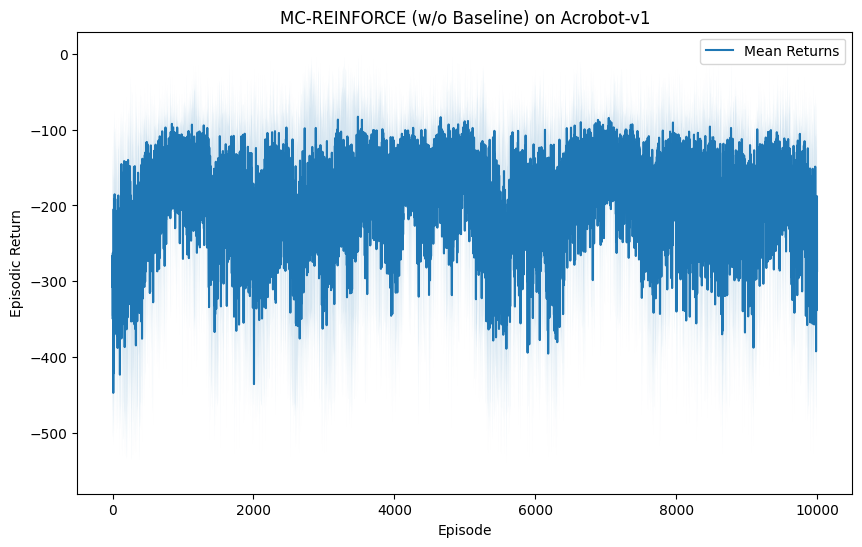

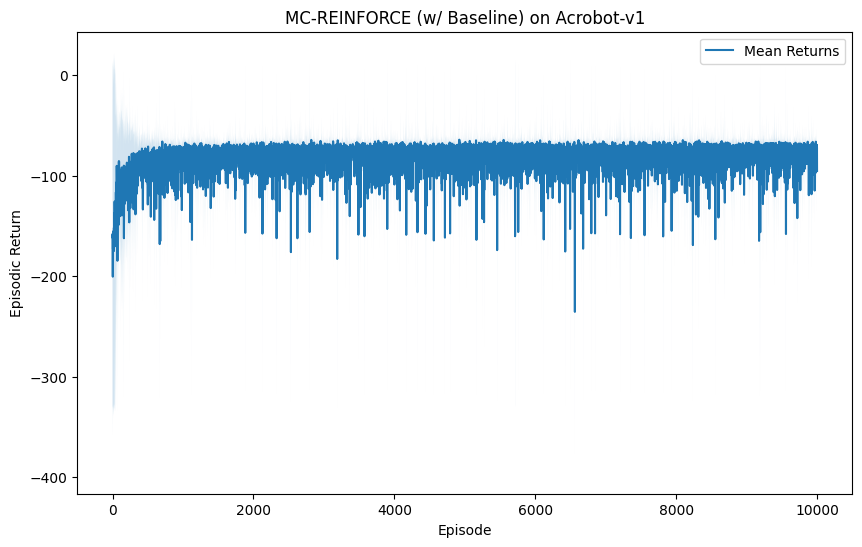

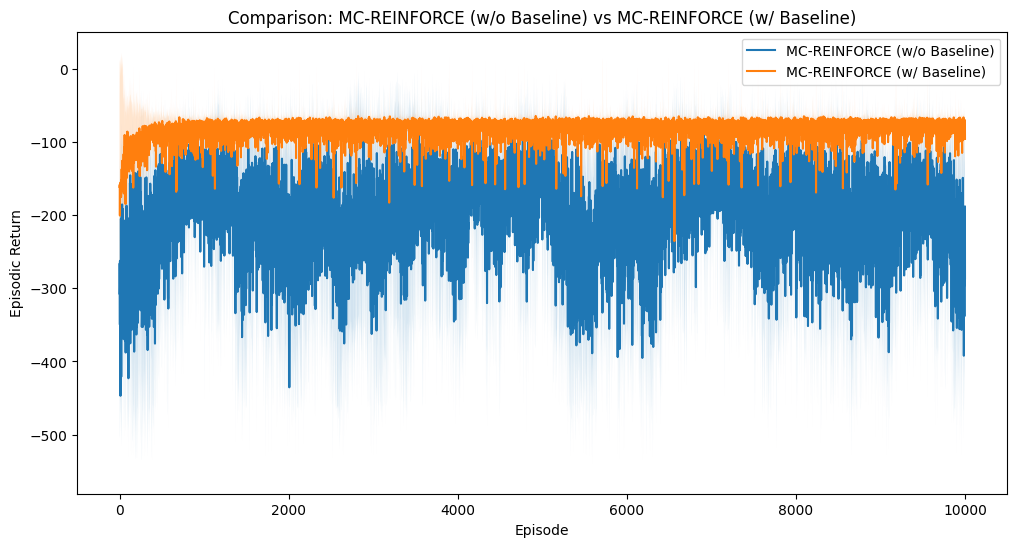

In [23]:

# Function to plot the episodic returns
def plot_returns(rewards, title, num_seeds=5):
    plt.figure(figsize=(10, 6))

    # Calculate mean and standard deviation across seeds
    rewards = np.array(rewards).reshape((num_seeds, -1))
    mean_rewards = np.mean(rewards, axis=0)
    std_rewards = np.std(rewards, axis=0)

    # Plot the mean episodic returns
    plt.plot(mean_rewards, label='Mean Returns')

    # Plot the standard deviation as a shaded region
    plt.fill_between(range(len(mean_rewards)),
                     mean_rewards - std_rewards,
                     mean_rewards + std_rewards,
                     alpha=0.2)

    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Episodic Return')
    plt.legend()
    plt.show()

# Function to compare the performance of two algorithms
def compare_algorithms(rewards1, rewards2, title1, title2):
    plt.figure(figsize=(12, 6))

    # Calculate mean and standard deviation across seeds
    rewards1 = np.array(rewards1).reshape((5, -1))
    rewards2 = np.array(rewards2).reshape((5, -1))
    mean_rewards1 = np.mean(rewards1, axis=0)
    mean_rewards2 = np.mean(rewards2, axis=0)
    std_rewards1 = np.std(rewards1, axis=0)
    std_rewards2 = np.std(rewards2, axis=0)

    # Plot the mean episodic returns for both algorithms
    plt.plot(mean_rewards1, label=title1)
    plt.plot(mean_rewards2, label=title2)

    # Plot the standard deviation as a shaded region
    plt.fill_between(range(len(mean_rewards1)),
                     mean_rewards1 - std_rewards1,
                     mean_rewards1 + std_rewards1,
                     alpha=0.2)
    plt.fill_between(range(len(mean_rewards2)),
                     mean_rewards2 - std_rewards2,
                     mean_rewards2 + std_rewards2,
                     alpha=0.2)

    plt.title(f'Comparison: {title1} vs {title2}')
    plt.xlabel('Episode')
    plt.ylabel('Episodic Return')
    plt.legend()
    plt.show()
    
env_name = "Acrobot-v1"

plot_returns(rewards_reinforce, f'MC-REINFORCE (w/o Baseline) on {env_name}')
plot_returns(rewards_reinforce_baseline, f'MC-REINFORCE (w/ Baseline) on {env_name}')


# Compare the performance of MC-REINFORCE variants
compare_algorithms(rewards_reinforce, rewards_reinforce_baseline, 'MC-REINFORCE (w/o Baseline)', 'MC-REINFORCE (w/ Baseline)')

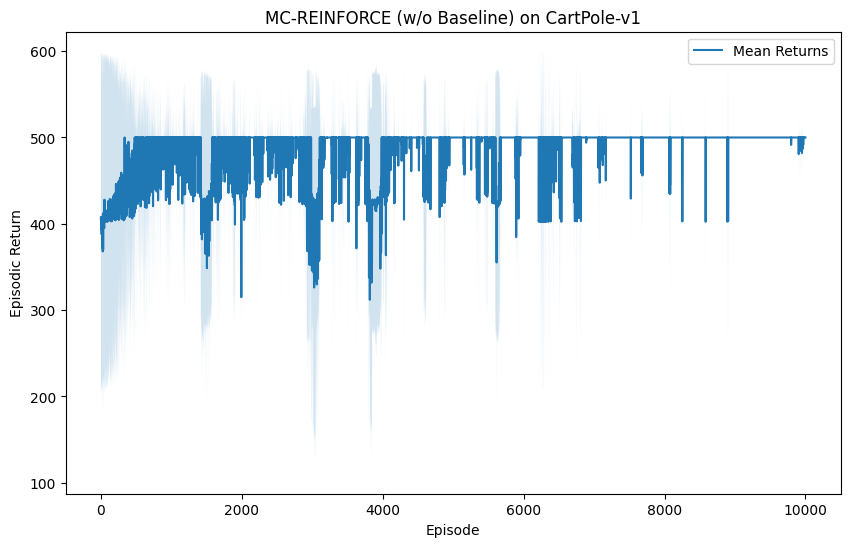

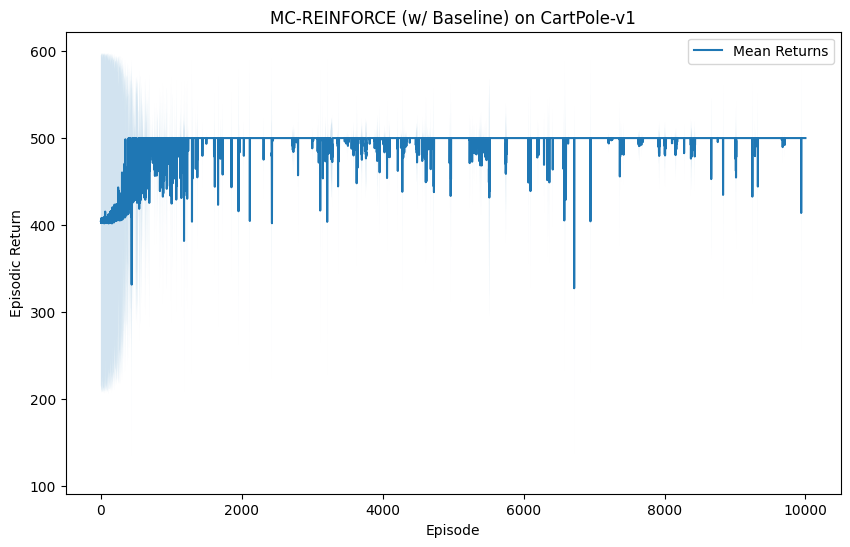

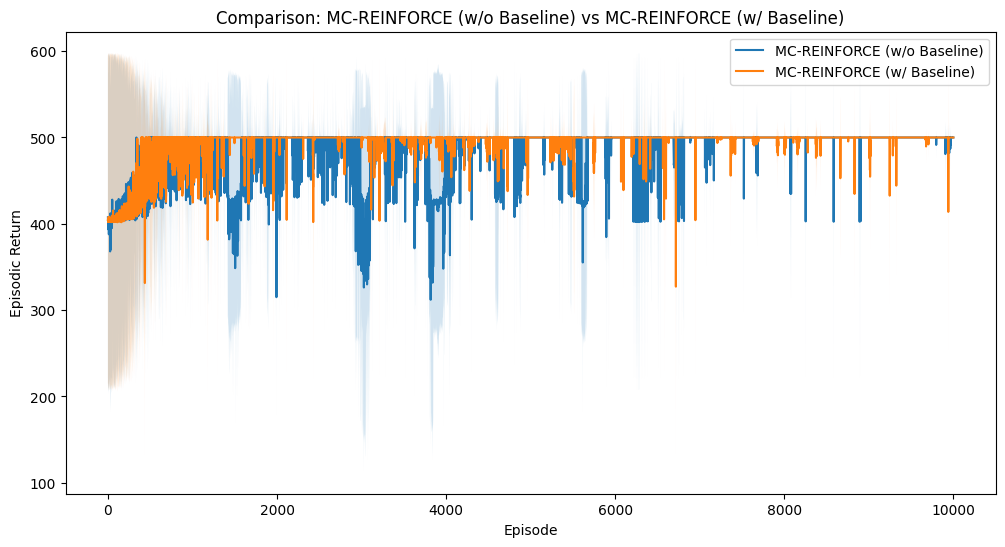

In [28]:
env_name = "CartPole-v1"

# Plot individual algorithm performance

plot_returns(rewards_reinforce, f'MC-REINFORCE (w/o Baseline) on {env_name}')
plot_returns(rewards_reinforce_baseline, f'MC-REINFORCE (w/ Baseline) on {env_name}')


# Compare the performance of MC-REINFORCE variants
compare_algorithms(rewards_reinforce, rewards_reinforce_baseline, 'MC-REINFORCE (w/o Baseline)', 'MC-REINFORCE (w/ Baseline)')